In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Malbecs
from malbecs.modeling import train as tr
import malbecs.modeling.transformers as mt

import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.ensemble import StackingRegressor, VotingRegressor

seed = 42


In [3]:
wine_path = "../../data/final/wine_final.csv"
eto_path = "../../data/final/eto_final.csv"
meteo_path = "../../data/final/meteo_final.csv"

def show_feat_imps(feat_imp, feat_names):
    pd.DataFrame(
        feat_imp,
        index=feat_names,
        columns=["feat_imp"]
    ).sort_values("feat_imp")[-50:].plot(kind='barh', figsize=(6, 15))

## Cargamos datos preprocesados

In [4]:
data = tr.load_final_data(
    wine_path=wine_path,
    eto_path=eto_path,
    meteo_path=meteo_path
)

In [5]:
with open("../../data/final/meteo_features.txt", "r", encoding="utf-8") as f:
    meteo_cols = f.read().split("\n")

with open("../../data/final/eto_features.txt", "r") as f:
    eto_cols = f.read().split("\n")

with open("../../data/final/wine_features.txt", "r") as f:
    wine_cols = f.read().split("\n")

Dejamos funcion para split y CV

In [9]:
data_train = tr.filter_camp(data.copy(), min_camp=15, max_camp=21)

data_final = tr.filter_camp(data, min_camp=22, max_camp=22)

train, test = tr.train_test_split(data_train, test_camp=21)

X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca',
    'id_zona',
    'id_estacion',
    'variedad',
    "modo",
    "tipo",
    "color",
    "prod_shift1_gt_shift2",
    "sup_is_nan",
]
num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)


Variables climáticas

In [10]:
percip_cols = [c for c in eto_cols if "Precip" in c]
snow_cols = [c for c in eto_cols if "Snow" in c]
temp_day_cols = [c for c in eto_cols if "TemperatureLocalDay" in c]
temp_cols = [
    c for c in eto_cols if "TemperatureLocalAfter" in c or "TemperatureLocalOvern" in c]
evotrans_cols = [c for c in eto_cols if "Evapotranspiration" in c]
feelslike_cols = [c for c in eto_cols if "FeelsLikeLoca" in c]
irrad_cols = [c for c in eto_cols if "Irradiance" in c]
gust_cols = [c for c in eto_cols if "Gust" in c]
wind_cols = [c for c in eto_cols if "Wind" in c]
dewpoint_cols = [c for c in eto_cols if "Dewpoint" in c]
mslp_cols = [c for c in eto_cols if "MSLP" in c]
humid_cols = [c for c in eto_cols if "Humidity" in c]
uvindex_cols = [c for c in eto_cols if "UVIndex" in c]
visib_cols = [c for c in eto_cols if "Visibility" in c]

tempuo = [c for c in eto_cols if ("Temp" in c) and ("StdM" in c )]
tempdiff = [c for c in eto_cols if ("Temp" in c) and ("Diff" in c)]
precipuo = [c for c in eto_cols if ("Precip" in c) and ("StdM" in c )]
precipdiff = [c for c in eto_cols if ("Precip" in c) and ("Diff" in c)]
snowpuo = [c for c in eto_cols if ("Snow" in c) and ("StdM" in c )]
snowpdiff = [c for c in eto_cols if ("Snow" in c) and ("Diff" in c)]
winduo = [c for c in eto_cols if ("Wind" in c) and ("StdM" in c )]
winddiff = [c for c in eto_cols if ("Wind" in c) and ("Diff" in c )]
gustuo = [c for c in eto_cols if ("Gust" in c) and ("StdM" in c)]
gustdiff = [c for c in eto_cols if ("Gust" in c) and ("Diff" in c)]

Variables extra producción

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def get_preprocesing():

    model_num_cols = [
        'campaña',
        'superficie',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
        'prod_he_var_zone_mean_hist_total',
        'prod_he_var_zone_std_hist_total',
        'prod_he_var_modo_zona_mean_shift1_total',
        "prod_he_var_modo_zona_change_total"
    ]

    return ColumnTransformer([

        ('Flag',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['sup_is_nan']),
        ('Zona_encoder',mt.TargetEncoder(), ['id_zona']),
        ('Zona_encoder_2',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['id_zona']),
        ('Variedad_encoder',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['variedad']),
        ('Modo_encoder',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['modo']),
        ('Numerics_encoder',StandardScaler(), model_num_cols),

        ('Temp_pipeline',Pipeline([('Temp_pipeline',StandardScaler()),('asdasd',PCA(n_components=3, random_state=seed))]), temp_cols),

        ('Under_over_scaler',StandardScaler(),[c for c in precipuo if "2Std" in c]),

        ('Precip_PCA',make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)),
             [c for c in percip_cols if 'Sum' in c]
        )],
        remainder='drop'
    )


In [23]:
prep = get_preprocesing()
model = RandomForestRegressor(
    random_state=seed,
    n_estimators=500,
    min_samples_leaf=4,
    n_jobs=-1,
    max_features=0.20,
    max_samples=0.8
)

m = make_pipeline(
    prep,
    model
)

res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True,

)

print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")

train:  [-4628.3377254  -4398.48711481 -4442.27470561]
test:  [-4835.54310361 -6739.44960258 -5258.11263034]
Train Mean RMSE: -4489.6998486044895
Test Mean RMSE: -5611.03511217436


In [24]:
m.fit(X,y)
y_pred_temp = m.predict(X_final)

In [25]:
def get_preprocesing_notemp():

    model_num_cols = [
        'campaña',
        'superficie',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
        'prod_he_var_zone_mean_hist_total',
        'prod_he_var_zone_std_hist_total',
        'prod_he_var_modo_zona_mean_shift1_total',
        "prod_he_var_modo_zona_change_total"
    ]

    return ColumnTransformer([

        ('Flag',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['sup_is_nan']),
        ('Zona_encoder',mt.TargetEncoder(), ['id_zona']),
        ('Zona_encoder_2',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['id_zona']),
        ('Variedad_encoder',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['variedad']),
        ('Modo_encoder',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['modo']),
        ('Numerics_encoder',StandardScaler(), model_num_cols),

        ('Under_over_scaler',StandardScaler(),[c for c in precipuo if "2Std" in c]),

        ('Precip_PCA',make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)),
             [c for c in percip_cols if 'Sum' in c]
        ),
        ("Snow",StandardScaler(),[c for c in snow_cols if 'Sum' in c and ("1" in c or "2" in c)]),
        ],

        remainder='drop'
    )

prep = get_preprocesing_notemp()

model = RandomForestRegressor(
    random_state=seed,
    n_estimators=500,
    min_samples_leaf=4,
    n_jobs=-1,
    max_features=0.20,
    max_samples=0.8
)

m = make_pipeline(
    prep,
    model
)
res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True,

)

print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")


train:  [-4799.10657187 -4554.70950316 -4573.13390607]
test:  [-4772.69965371 -6693.3883576  -5282.4933207 ]
Train Mean RMSE: -4642.316660367932
Test Mean RMSE: -5582.860444006027


In [ ]:
# train:  [-4628.3377254  -4398.48711481 -4442.27470561]
# test:  [-4835.54310361 -6739.44960258 -5258.11263034]
# Train Mean RMSE: -4489.6998486044895
# Test Mean RMSE: -5611.03511217436

# no temp + snow
# train:  [-4799.10657187 -4554.70950316 -4573.13390607]
# test:  [-4772.69965371 -6693.3883576  -5282.4933207 ]
# Train Mean RMSE: -4642.316660367932
# Test Mean RMSE: -5582.860444006027


In [26]:

m.fit(X,y)
y_pred_notemp = m.predict(X_final)

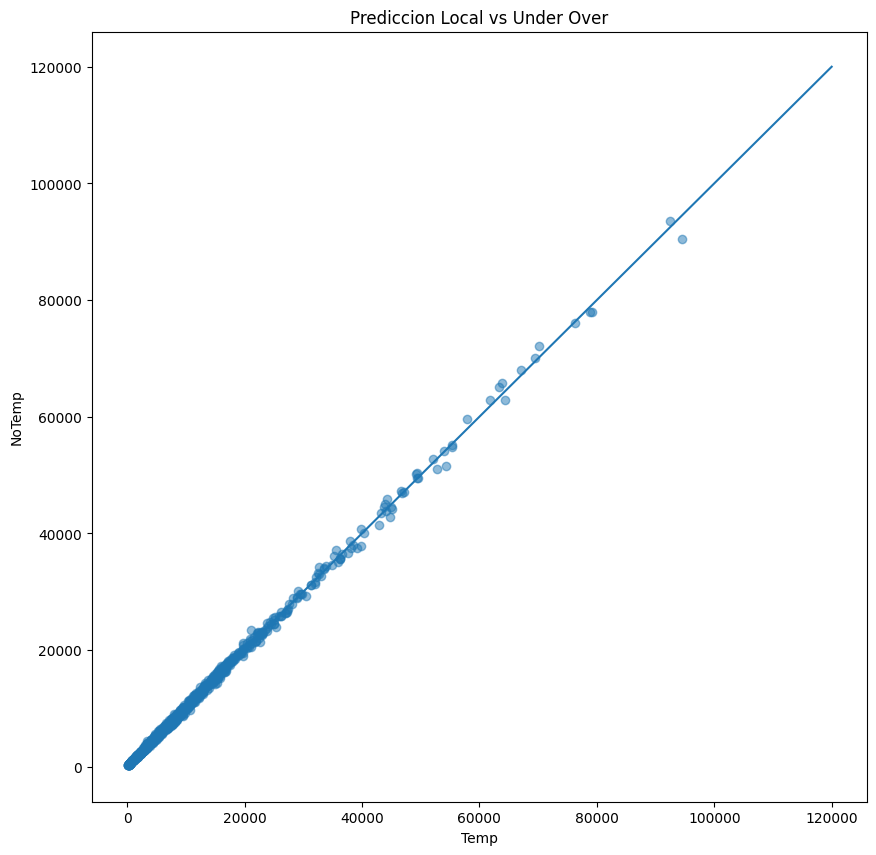

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(y_pred_temp, y_pred_notemp, alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('Temp')
plt.ylabel('NoTemp')
plt.title('Prediccion Local vs Under Over')
plt.show()


### Comparar vs original

In [32]:
df_preds = pd.read_csv('../../data/final/Malbecs.txt',sep='|',header=None)
preds_originales = df_preds[6]

Ajustamos modelo para 2022

In [33]:
x_test_2022 = data_final.drop(columns=['produccion'])

In [34]:
m.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinalencoder-1',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['sup_is_nan']),
                                                 ('targetencoder',
                                                  TargetEncoder(),
                                                  ['id_zona']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['id_zona']),
                                                 ('ordinalencoder-3',
                                                  OrdinalEnc...
                                                  ['SumTotalPrecipAmountLocalDayMonth1',
                                                   'SumTotalPrecipAmountLocalDayMonth2',
                                                   'SumTotalPrecipAmountLocalDayMonth3',
                                                   'SumTotalPrecipAmountLocalDayMonth4',
                                                   'SumTotalPrecipAmountLocalDayMonth5',
                                                   'SumTotalPrecipAmountLocalDayMonth6'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=0.2, max_samples=0.8,
                                       min_samples_leaf=4, n_estimators=500,
                                       n_jobs=-1, random_state=42))])

In [35]:
preds_2022 = m.predict(x_test_2022)

In [36]:
df_preds_22 = data_final[['id_finca', 'variedad','modo','tipo','color','superficie']].copy()
df_preds_22['produccion'] = preds_2022
df_preds_22 = df_preds_22.sort_values(['id_finca', 'variedad','modo','tipo','color','superficie'], ascending=True)

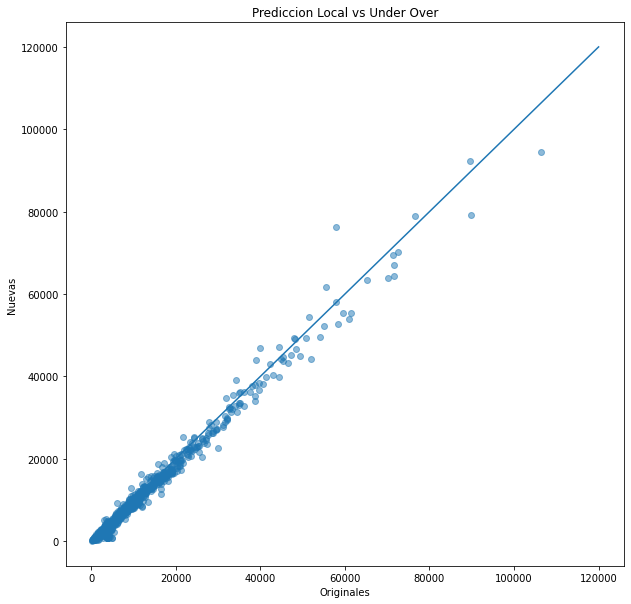

In [49]:
plt.figure(figsize=(10,10))
plt.scatter(preds_originales, df_preds_22['produccion'], alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('Originales')
plt.ylabel('Nuevas')
plt.title('Prediccion Local vs Under Over')
plt.show()

In [39]:
df_preds_22.to_csv('../../data/final/intermedia-nacional/UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_1.txt', sep="|", header=None, index=False)

## Modelo original sin cambiar mucho 

In [40]:
data_train = tr.filter_camp(data.copy(), min_camp=15, max_camp=21)

data_final = tr.filter_camp(data, min_camp=22, max_camp=22)

train, test = tr.train_test_split(data_train, test_camp=21)

X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca',
    'id_zona',
    'id_estacion',
    'variedad',
    "modo",
    "tipo",
    "color",
    "prod_shift1_gt_shift2",
    "sup_is_nan",
]
num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)


In [41]:
n_fincas = X['id_finca'].nunique()
top_fincas = X.id_finca.value_counts()[:int(0.8*n_fincas)].index.values.tolist()
X['id_finca_top'] = X['id_finca'].apply(lambda x: x if x in top_fincas else -1)

n_zonas = X['id_zona'].nunique()
top_zonas = X['id_zona'].value_counts()[:int(0.8*n_zonas)].index.values.tolist()
X['id_zona_top'] = X['id_zona'].apply(lambda x: x if x in top_zonas else -1)

n_var = X['variedad'].nunique()
top_variedad= X['variedad'].value_counts()[:int(0.8*n_var)].index.values.tolist()
X['variedad_top'] = X['variedad'].apply(
    lambda x: x if x in top_variedad else -1)


In [42]:
percip_cols = [c for c in eto_cols if "Precip" in c]
snow_cols = [c for c in eto_cols if "Snow" in c]

In [43]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, HuberRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, StandardScaler
import pickle as pkl
from typing import List
import malbecs.modeling.transformers as mt
from sklearn.decomposition import PCA

seed = 42

def get_base_model_v2():

    model_num_cols = [
        'superficie',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
    ]

    m = make_pipeline(
        make_column_transformer(

            (mt.BaseNEncoder(), ['id_finca']),

            (mt.TargetEncoder(), ['id_zona']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['id_estacion']),

            (mt.BaseNEncoder(), ['variedad']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['modo']),

            (KBinsDiscretizer(n_bins=2), ['altitud']),

            (StandardScaler(), model_num_cols),

            (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)),[c for c in percip_cols if 'Sum' in c]),
            
            (StandardScaler(),[c for c in snow_cols if 'Sum' in c and ("1" in c or "2" in c)]),

            remainder='drop'
        ),
        RandomForestRegressor(
            random_state=seed,
            n_estimators=200,
            min_samples_leaf=4,
            n_jobs=-1,
            max_features='sqrt',
            max_samples=0.8
        )
    )
    return m


In [44]:
from sklearn.model_selection import cross_validate
import numpy as np

m_nuevo = get_base_model_v2()
res = cross_validate(
    estimator=m_nuevo,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True,
    fit_params={
        # "randomforestregressor__sample_weight": sample_weight
        # "stackingregressor__sample_weight": sample_weight
    }
)


print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")

train:  [-4762.75172392 -4546.54217991 -4609.76228565]
test:  [-4828.66303666 -6695.44632565 -5414.76235157]
Train Mean RMSE: -4639.685396494778
Test Mean RMSE: -5646.290571291902


Ajustamos para 2022

In [45]:
x_test_v2 = data_final.drop(columns=['produccion'])

In [46]:
m_nuevo = get_base_model_v2()
m_nuevo.fit(X,y)
preds_nuevas = m_nuevo.predict(x_test_v2)

In [47]:
preds_final_v2 = data_final[['id_finca', 'variedad','modo','tipo','color','superficie']].copy()
preds_final_v2['produccion'] = preds_nuevas
preds_final_v2 = preds_final_v2.sort_values(['id_finca', 'variedad','modo','tipo','color','superficie'], ascending=True)

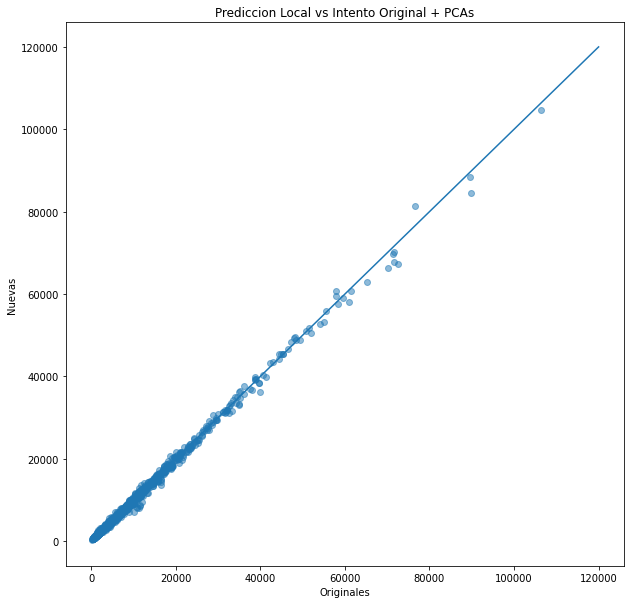

In [51]:
plt.figure(figsize=(10,10))
plt.scatter(preds_originales, preds_final_v2['produccion'], alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('Originales')
plt.ylabel('Nuevas')
plt.title('Prediccion Local vs Intento Original + PCAs')
plt.show()

In [52]:
preds_final_v2

,id_finca,variedad,modo,tipo,color,superficie,produccion
9041,439,9,2,0,0,1.0800,3620.716053
9022,447,40,2,0,1,0.4694,2525.368637
8718,523,32,2,0,1,0.6478,2086.596596
9249,702,59,2,0,1,1.1331,7758.320964
9305,797,59,1,0,1,7.5143,11859.437809
...,...,...,...,...,...,...,...
9223,99282,59,2,0,1,1.6244,7654.657389
9099,99377,52,2,0,1,0.6500,2559.978122
9507,99693,81,1,0,1,6.3397,28861.280945
8556,99793,52,2,0,1,0.1326,3874.175085


In [53]:
preds_final_v2.to_csv('../../data/final/intermedia-nacional/UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_2.txt', sep="|", header=None, index=False)